<a href="https://colab.research.google.com/github/luckyswaminathan/MusicVibe/blob/main/gloVeNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## imports
## gloVe credits: 
## Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]
## am adapting structure given by https://www.youtube.com/watch?v=e0WW5w13V64&t=68s&ab_channel=GregHogg to create 
## an NLP model for my app Music Vibe (data source requires no credits as is open source)
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
url = 'https://raw.githubusercontent.com/luckyswaminathan/MusicVibe/main/tweet_emotions.csv'

msc_df = pd.read_csv(url)


sentiment_mapping = dict.fromkeys(["anger", "hate", "sadness", "worry"], (np.array([1,0,0])))

sentiment_mapping.update(dict.fromkeys(["boredom", "empty", "neutral"], (np.array([0,1,0]))))

sentiment_mapping.update(dict.fromkeys(["enthusiasm", "fun", "happiness", "love", "relief", "surprise"], (np.array([0,0,1]))))

msc_df['sentiment'] = msc_df['sentiment'].map(sentiment_mapping)

# Map the sentiment values using the mapping dictionary


# Check the value counts
msc_df['sentiment'].value_counts()



[0, 0, 1]    15299
[1, 0, 0]    15057
[0, 1, 0]     9644
Name: sentiment, dtype: int64

In [ ]:
## using gloVE rather than word2vec because works better with small dataset

!wget http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip

--2023-06-10 22:00:17--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip.1’

glove.twitter.27B.z 100%[===================>]   1.42G  5.07MB/s    in 4m 46s  

2023-06-10 22:05:02 (5.08 MB/s) - ‘glove.twitter.27B.zip.1’ saved [1520408563/1520408563]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!unzip glove.twitter.27B.zip.1

Archive:  glove.twitter.27B.zip.1
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [12]:
words = dict()
def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')
      d[line[0]] = np.array(line[1:], dtype=float)

add_to_dict(words, 'glove.twitter.27B.50d.txt')
len(words)

1193514

In [13]:
import nltk as nl
nl.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [14]:
tokenizer = nl.RegexpTokenizer(r"\w+")

## LEMMATIZATION -- concatenating variants of a word to one form

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()


## tokenizes and lemmatizes all words that are in gloVe word set
def tokenLem(s):
  tokens = tokenizer.tokenize(s)
  tokens = [word.lower() for word in tokens]
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  tokens = [word for word in tokens if word in words]

  return tokens


In [15]:
def message_to_word_vectors(message, word_dict=words):
  processed_list_of_tokens = tokenLem(message)

  vectors = []

  for token in processed_list_of_tokens:
    if token not in word_dict:
      continue
    
    token_vector = word_dict[token]
    vectors.append(token_vector)
  
  return np.array(vectors, dtype=float)

  

In [17]:
## train_test_split



train_df, mix_df = train_test_split(msc_df, random_state=42, test_size = 0.3)

val_df, test_df = train_test_split(mix_df, random_state=42, test_size = 0.5)


len(train_df), len(val_df), len(test_df)


(28000, 6000, 6000)

In [18]:
## splitting train,val, test into sentiment and content 


def df_to_SC(dff):
  ## sentiment for sentence
  y = dff['sentiment'].to_numpy()

  ## content array
  all_word_vector_sequences = []

  for message in dff['content']:
    message_as_vector_seq = message_to_word_vectors(message)
    
    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq)
  
  return all_word_vector_sequences, y




In [19]:
word_train, feel_train = df_to_SC(train_df)

len(word_train[0])

26

(array([3180., 4294., 5883., 3589., 4014., 2663., 2932., 1152.,  282.,
          11.]),
 array([ 1. ,  4.5,  8. , 11.5, 15. , 18.5, 22. , 25.5, 29. , 32.5, 36. ]),
 <BarContainer object of 10 artists>)

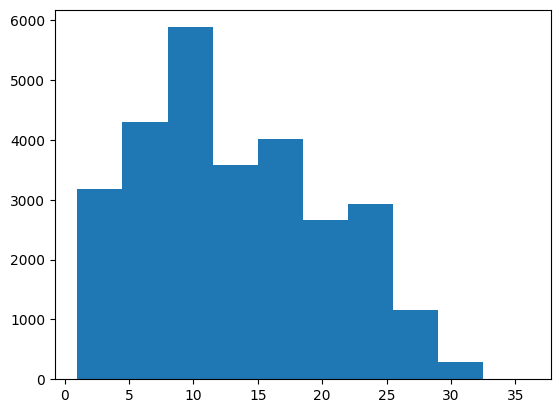

In [20]:
sequence_lengths = []

for i in range(len(word_train)):
  sequence_lengths.append(len(word_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)

In [21]:
## making the df into a np array

from copy import deepcopy

def pad_X(X, desired_sequence_length=38):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len
    
    pad = np.zeros(shape=(sequence_length_difference, 50))

    X_copy[i] = np.concatenate([x, pad])
  
  return np.array(X_copy).astype(float)

In [22]:
word_train = pad_X(word_train)
print(len(word_train[0]))


word_val, feel_val = df_to_SC(val_df)
word_val = pad_X(word_val)

word_test, feel_test = df_to_SC(test_df)
word_test = pad_X(word_test)




38


In [23]:
## LSTM model

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(layers.Input(shape=(38, 50)))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))


In [49]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint('model/', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss=CategoricalCrossentropy(), 
              metrics=['accuracy', AUC(name='auc')])

In [41]:
print(feel_train)

[array([1, 0, 0]) array([0, 1, 0]) array([0, 1, 0]) ... array([0, 0, 1])
 array([1, 0, 0]) array([0, 0, 1])]


In [47]:
frequencies = pd.value_counts(train_df['sentiment']) 
print(frequencies)
## weighting loss function as datset imbalanced

weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1], 2: frequencies.sum() / frequencies[2]}
weights

[0, 0, 1]    10695
[1, 0, 0]    10580
[0, 1, 0]     6725
Name: sentiment, dtype: int64


{0: 2.6180458158017763, 1: 2.6465028355387523, 2: 4.163568773234201}

In [50]:
word_train = word_train.astype(np.float32)
word_val = word_val.astype(np.float32)




# Convert elements of feel_train to float32 type
feel_train = np.array([np.array(arr, dtype=np.float32) for arr in feel_train])
feel_val = np.array([np.array(arr, dtype=np.float32) for arr in feel_val])


In [51]:


model.fit(tf.convert_to_tensor(word_train), tf.convert_to_tensor(feel_train), validation_data=(tf.convert_to_tensor(word_val), tf.convert_to_tensor(feel_val)), epochs=20, callbacks=[cp], class_weight=weights)


Epoch 1/20
875/875 [==============================] - ETA: 0s - loss: 3.0454 - accuracy: 0.4793 - auc: 0.6787

875/875 [==============================] - 121s 131ms/step - loss: 3.0454 - accuracy: 0.4793 - auc: 0.6787 - val_loss: 0.9900 - val_accuracy: 0.5237 - val_auc: 0.7064
Epoch 2/20
875/875 [==============================] - ETA: 0s - loss: 2.8881 - accuracy: 0.5411 - auc: 0.7249

875/875 [==============================] - 102s 117ms/step - loss: 2.8881 - accuracy: 0.5411 - auc: 0.7249 - val_loss: 0.9436 - val_accuracy: 0.5688 - val_auc: 0.7415
Epoch 3/20
875/875 [==============================] - ETA: 0s - loss: 2.8495 - accuracy: 0.5520 - auc: 0.7353

875/875 [==============================] - 101s 116ms/step - loss: 2.8495 - accuracy: 0.5520 - auc: 0.7353 - val_loss: 0.9336 - val_accuracy: 0.5693 - val_auc: 0.7442
Epoch 4/20
875/875 [==============================] - ETA: 0s - loss: 2.8235 - accuracy: 0.5575 - auc: 0.7411

875/875 [==============================] - 95s 109ms/step - loss: 2.8235 - accuracy: 0.5575 - auc: 0.7411 - val_loss: 0.9246 - val_accuracy: 0.5735 - val_auc: 0.7503
Epoch 5/20
875/875 [==============================] - ETA: 0s - loss: 2.8055 - accuracy: 0.5646 - auc: 0.7456

875/875 [==============================] - 112s 128ms/step - loss: 2.8055 - accuracy: 0.5646 - auc: 0.7456 - val_loss: 0.9229 - val_accuracy: 0.5767 - val_auc: 0.7539
Epoch 6/20
875/875 [==============================] - 82s 93ms/step - loss: 2.7938 - accuracy: 0.5644 - auc: 0.7484 - val_loss: 0.9444 - val_accuracy: 0.5690 - val_auc: 0.7424
Epoch 7/20
875/875 [==============================] - ETA: 0s - loss: 2.7795 - accuracy: 0.5673 - auc: 0.7515

875/875 [==============================] - 99s 113ms/step - loss: 2.7795 - accuracy: 0.5673 - auc: 0.7515 - val_loss: 0.9103 - val_accuracy: 0.5848 - val_auc: 0.7602
Epoch 8/20
875/875 [==============================] - 98s 112ms/step - loss: 2.7665 - accuracy: 0.5713 - auc: 0.7547 - val_loss: 0.9524 - val_accuracy: 0.5618 - val_auc: 0.7415
Epoch 9/20
875/875 [==============================] - 98s 112ms/step - loss: 2.7538 - accuracy: 0.5748 - auc: 0.7569 - val_loss: 0.9225 - val_accuracy: 0.5848 - val_auc: 0.7584
Epoch 10/20
875/875 [==============================] - 92s 106ms/step - loss: 2.7425 - accuracy: 0.5795 - auc: 0.7598 - val_loss: 0.9284 - val_accuracy: 0.5747 - val_auc: 0.7510
Epoch 11/20
875/875 [==============================] - 97s 111ms/step - loss: 2.7245 - accuracy: 0.5833 - auc: 0.7636 - val_loss: 0.9363 - val_accuracy: 0.5713 - val_auc: 0.7516
Epoch 12/20
875/875 [==============================] - ETA: 0s - loss: 2.7173 - accuracy: 0.5822 - auc: 0.7651

875/875 [==============================] - 112s 128ms/step - loss: 2.7173 - accuracy: 0.5822 - auc: 0.7651 - val_loss: 0.9048 - val_accuracy: 0.5923 - val_auc: 0.7651
Epoch 13/20
875/875 [==============================] - 82s 94ms/step - loss: 2.7001 - accuracy: 0.5890 - auc: 0.7688 - val_loss: 0.9338 - val_accuracy: 0.5687 - val_auc: 0.7514
Epoch 14/20
875/875 [==============================] - 75s 86ms/step - loss: 2.6963 - accuracy: 0.5914 - auc: 0.7695 - val_loss: 0.9166 - val_accuracy: 0.5777 - val_auc: 0.7577
Epoch 15/20
875/875 [==============================] - ETA: 0s - loss: 2.6832 - accuracy: 0.5908 - auc: 0.7721

875/875 [==============================] - 91s 104ms/step - loss: 2.6832 - accuracy: 0.5908 - auc: 0.7721 - val_loss: 0.9046 - val_accuracy: 0.5852 - val_auc: 0.7663
Epoch 16/20
875/875 [==============================] - 84s 96ms/step - loss: 2.6738 - accuracy: 0.5932 - auc: 0.7739 - val_loss: 0.9274 - val_accuracy: 0.5745 - val_auc: 0.7541
Epoch 17/20
875/875 [==============================] - ETA: 0s - loss: 2.6701 - accuracy: 0.5944 - auc: 0.7750

875/875 [==============================] - 101s 115ms/step - loss: 2.6701 - accuracy: 0.5944 - auc: 0.7750 - val_loss: 0.8979 - val_accuracy: 0.5937 - val_auc: 0.7703
Epoch 18/20
875/875 [==============================] - 90s 103ms/step - loss: 2.6608 - accuracy: 0.5958 - auc: 0.7768 - val_loss: 0.9131 - val_accuracy: 0.5847 - val_auc: 0.7609
Epoch 19/20
875/875 [==============================] - 89s 102ms/step - loss: 2.6491 - accuracy: 0.5995 - auc: 0.7791 - val_loss: 0.9146 - val_accuracy: 0.5840 - val_auc: 0.7612
Epoch 20/20
875/875 [==============================] - 86s 99ms/step - loss: 2.6448 - accuracy: 0.6002 - auc: 0.7800 - val_loss: 0.9108 - val_accuracy: 0.5865 - val_auc: 0.7647


In [52]:
from tensorflow.keras.models import load_model

best_model = load_model('model/')

In [69]:

test_predictions = best_model.predict(word_test)
print(test_predictions)

# from sklearn.metrics import classification_report

# print(classification_report(feel_test, test_predictions))

188/188 [==============================] - 6s 33ms/step
[[0.12367542 0.25386485 0.6224598 ]
 [0.7277098  0.09531482 0.17697537]
 [0.24751244 0.06720192 0.6852857 ]
 ...
 [0.52078307 0.16503447 0.3141825 ]
 [0.1668983  0.17239393 0.6607078 ]
 [0.8534571  0.08443864 0.06210428]]
